# 第五章 图像处理    

> 图像处理时要提防高位溢出问题.    

## 尺寸调整    

放大或缩小图像时会使用 resize() 函数.    

**cv2.resize() 函数** :    
- 原型: cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) → dst;   
- 第一个参数是要进行 resize 的原图;    
- 第二个参数输入是 宽×高×通道, 如果没有通道, 则和原图通道数相同;  
- interpolation 参数指定 resize 时使用的插值方法, 默认为线性插值法. 可以有如下插值方式.    
```
INTER_NEAREST - a nearest-neighbor interpolation
INTER_LINEAR - a bilinear interpolation (used by default)
INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood
```


**几种不同插值方法介绍:**    
- 线性插值(INTER_LINEAR): 目标图上像素值是原图附近的 4 个(2x2范围)邻近像素的线性加权值, 权重由这4个像素到精确目标点的距离决定.    
- 区域插值(INTER_AREA): 使用新的像素点覆盖原来的像素点, 然后求取覆盖区域的平均值.     
- 三次样条插值(INTER_CUBIC): 首先对原图像附近的 4x4 个邻近像素进行三次样条拟合, 然后将目标像素对应的三次样条值作为目标图像对应像素点的值.   

In [1]:
## 图像 resize 操作.   
import cv2

image = cv2.imread("../pictures_for_code/building.jpg")

cv2.imshow("image", image)
h,w = image.shape[:2]     # 注意宽和高的顺序.
print(image.size)         # 注意区分 python 和 cpp 中 shape 和 size 的对应关系.   
resized = cv2.resize(image, (int(w/2),int(h/2)), interpolation=cv2.INTER_CUBIC)
cv2.imshow("resized image", resized)
key = cv2.waitKey(0)
if key:
    cv2.destroyAllWindows()

518400


## 图像金字塔     
   
通过对原始图像进行连续降采样获得. 常用的图像金字塔分为高斯金字塔和拉普拉斯金字塔, 高斯金字塔一般用于下采样, 而拉普拉斯金字塔用于上采样重建图像.   

要从金字塔的第 i 层(G_i)生成第 i+1 层(G_{i+1}), 我们需要先用高斯核对 G_i 层进行卷积, 然后删除所有的偶数行和偶数列. 当然新得到的图像面积会变为原图像的 1/4. 将上述过程对输入图像 G_0 循环执行操作即可产生整个金字塔.     

图像的拉普拉斯金字塔可以由图像的高斯金字塔得到，转换的公式为：     
L_i = G_i - PyrUp(G_{i+1})

**cv2.pyrUp()函数与cv2.pyrDown()**:     
- cv2.pyrUp(src[, dst[, dstsize[, borderType]]]) → dst;     
- cv2.pyrDown(src[, dst[, dstsize[, borderType]]]) → dst;   
- 先对图像执行 cv2.pyrDown() 缩小一般之后再对图像放大一倍, 虽然图像的尺寸还是不变, 但是分辨率已经大大降低.   


In [2]:
## 图像金字塔  
image_down = cv2.pyrDown(image)
image_up_to_origin = cv2.pyrUp(image_down)

cv2.imshow("down", image_down) 
cv2.imshow("up", image_up_to_origin) 
cv2.imshow("origin", image) 

key = cv2.waitKey(0)
if key:
    cv2.destroyAllWindows()

## 阈值化     

可以直接剔除一些高于或低于一定值的像素.     

**cv2.threshold()函数**:     
- 函数实现的核心思想很简单: 给定一个数组和一个阈值, 然后根据数组中元素值是低于还是高于阈值来进行一些特定类型的处理.    
- 目标图像的像素可能被设置为 0, src{i} 或 maxval.    
- cv2.threshold(src, thresh, maxval, type[, dst]) → retval, dst;    
- thresh – threshold value.   
- maxval – maximum value to use with the THRESH_BINARY and THRESH_BINARY_INV thresholding types.   
- type – 指定阈值化类型.   


**type 的可选类型**:   
THRESH_BINARY:　大于阈值的设置为最大值,  小于阈值的设置为 ０.　　　
THRESH_BINARY_INV: 和 THRESH_BINARY 相反，大于阈值的设置为最大值， 小于阈值的设置为 ０.    
THRESH_TRUNC： 小于阈值的保持原值， 大于阈值的被截断为阈值最大值(这时最大值和阈值设置为相同值).   
THRESH_TOZERO: 小于阈值的保持原值, 大于阈值的被设置为 0.   
THRESH_TOZERO_INV: 和 THRESH_TOZERO 相反, 大于阈值的保持原值, 小于阈值的被设置为 0.   

## 自适应阈值    

这是一种改进了的阈值技术,其中的阈值本身就是一个变化的量.    

**cv2.adaptiveThreshold() 函数**:    
- cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst]) → dst;     
- maxValue – Non-zero value assigned to the pixels for which the condition is satisfied. See the details below.   
- adaptiveMethod – 指定要使用的自适应阈值算法, ADAPTIVE_THRESH_MEAN_C 或 ADAPTIVE_THRESH_GAUSSIAN_C.后面还会有详细说明.   
- thresholdType – 阈值类型, 只能是 THRESH_BINARY 或 THRESH_BINARY_INV.   
- blockSize – 计算阈值的像素领域的大小: 可选值为 3, 5, 7, 等等的奇数.   
- C – 要减去的均值常量. 通常情况下为正数.    
- 原图像使用的每个像素点处使用的阈值都是被单独计算的.    
- 对于 ADAPTIVE_THRESH_MEAN_C , 阈值的计算方式为 blockSize x blockSize 范围内像素的平均值减去 C.   
- 对于 ADAPTIVE_THRESH_GAUSSIAN_C , 阈值的计算方式为 blockSize x blockSize 范围内像素的加权平均值减去 C, 权值为高斯函数按照邻域内像素点离中心的距离.    
- 该函数支持 in-place.   

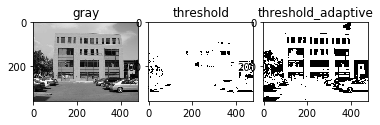

In [22]:
## 阈值化和自适应阈值的比较   
import matplotlib.pyplot as plt

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, threshold = cv2.threshold(image_gray, 15, 255, cv2.THRESH_BINARY)
threshold_adaptive = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 81, 15)

#cv2.imshow("gray", image_gray) 
#cv2.imshow("threshold", threshold) 
#cv2.imshow("threshold_adaptive", threshold_adaptive) 

# TODO: how to set the size of subplots? 
plt.subplots_adjust(hspace=0.1, wspace=0.1)     ## 调节子图之间的间距
plt.subplot(131), plt.imshow(image_gray, "gray"), plt.title("gray")
plt.subplot(132), plt.imshow(threshold, "gray"), plt.title("threshold")
plt.subplot(133), plt.imshow(threshold_adaptive, "gray"), plt.title("threshold_adaptive")

plt.show()
#key = cv2.waitKey(0)
#if key:
#    cv2.destroyAllWindows()